# Ï†ïÍ∑úÌôî ÎØ∏Ï†ÅÏö©

[TRAIN] ÍµêÏßëÌï© Í∞úÏàò: 1619 / TS=1619 ST=1619
[VALID] ÍµêÏßëÌï© Í∞úÏàò: 180 / TS=180 ST=180
[TEST] ÍµêÏßëÌï© Í∞úÏàò: 272 / TS=272 ST=272


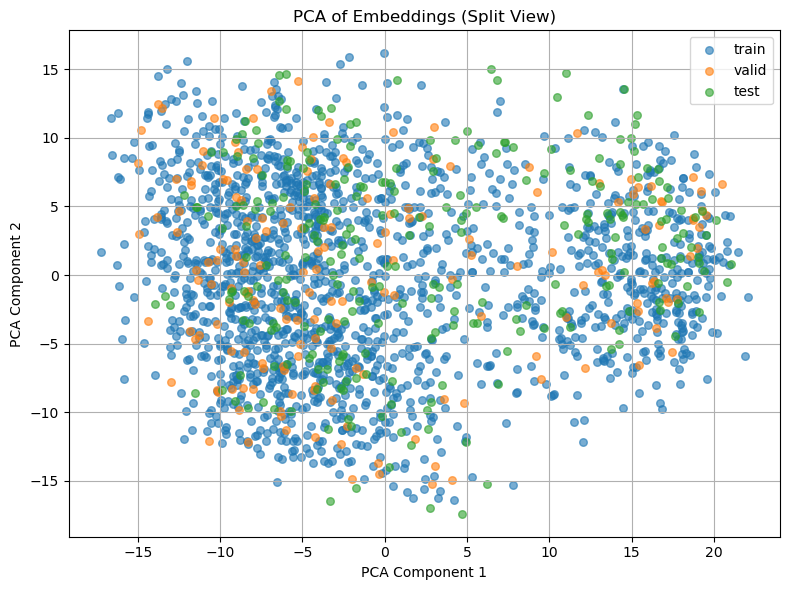

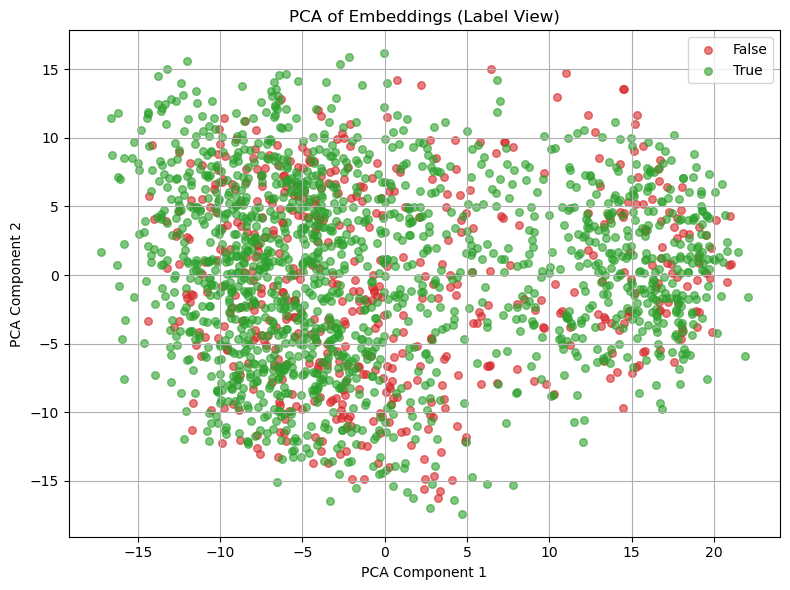

In [20]:
# üìå ÌÜµÌï© PCA ÏãúÍ∞ÅÌôî: TimeSformer + ST-GCN Ï†ïÎ†¨ Ìè¨Ìï®
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
DATA_ROOT = Path(r"D:\Jabez\golf\fusion\embedding_data")
AGG_METHOD = "flatten"  # "mean", "max", "flatten" Ï§ë ÏÑ†ÌÉù

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Ìï®Ïàò Ï†ïÏùò ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def load_split(split, model):
    base = DATA_ROOT / model / split
    emb_path = base / "embeddings.npy"
    lbl_path = base / "labels.npy"
    ids_path = base / "ids.npy"
    if not emb_path.exists() or not lbl_path.exists() or not ids_path.exists():
        return None, None, None
    emb = np.load(emb_path)
    lbl = np.load(lbl_path).ravel()
    ids = np.load(ids_path, allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if arr is None or len(arr) == 0:
        return np.empty((0, 0))
    if AGG_METHOD == "mean":    return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":     return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten": return arr.reshape(arr.shape[0], -1)
    raise ValueError("Invalid AGG_METHOD")

def align_by_ids(base_ids, target_embs, target_ids):
    id_to_emb = {k: v for k, v in zip(target_ids, target_embs)}
    aligned_embs = [id_to_emb[i] for i in base_ids if i in id_to_emb]
    return np.array(aligned_embs)

def load_and_align(split):
    X_ts, y, ids_ts = load_split(split, "timesformer")
    X_st, _, ids_st = load_split(split, "stgcnpp")

    if X_ts is None or X_st is None:
        return np.empty((0, 0)), np.array([])

    # ÎßåÏïΩ ÌÉÄÏûÖÏù¥ Îã§Î•¥Î©¥ strÎ°ú ÌÜµÏùº
    ids_ts = np.array(ids_ts).astype(str)
    ids_st = np.array(ids_st).astype(str)

    inter = set(ids_ts) & set(ids_st)
    print(f"[{split.upper()}] ÍµêÏßëÌï© Í∞úÏàò: {len(inter)} / TS={len(ids_ts)} ST={len(ids_st)}")
    if len(inter) == 0:
        print(f"‚ùå {split} : Îëê ids Í∞Ñ ÍµêÏßëÌï©Ïù¥ 0Í∞úÏûÖÎãàÎã§. ÌååÏùº, ÌÉÄÏûÖ, Í≤ΩÎ°ú Ïû¨ÌôïÏù∏ ÌïÑÏöî!")
        return np.empty((0, 0)), np.array([])

    X_st = align_by_ids(ids_ts, X_st, ids_st)
    X_st = reduce_stgcn(X_st)

    if len(X_ts) != len(X_st):
        print(f"‚ùå {split} Ï†ïÎ†¨ Ïã§Ìå®: TS={len(X_ts)}, ST={len(X_st)}")
        return np.empty((0, 0)), np.array([])

    X_concat = np.concatenate([X_ts, X_st], axis=1)
    return X_concat, y


# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Ï†ïÎ†¨ Î∞è Í≤∞Ìï© ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
X_tr, y_tr = load_and_align("train")
X_va, y_va = load_and_align("valid")
X_te, y_te = load_and_align("test")

X_all = np.vstack([X_tr, X_va, X_te])
y_all_split = (
    ["train"] * len(X_tr) +
    ["valid"] * len(X_va) +
    ["test"]  * len(X_te)
)
y_all_label = np.concatenate([y_tr, y_va, y_te])

if len(X_all) == 0:
    raise ValueError("Î™®Îì† splitÏóêÏÑú Ï†ïÎ†¨Îêú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§. Í≤ΩÎ°ú Î∞è ID Ï†ïÎ†¨ ÏÉÅÌÉúÎ•º ÌôïÏù∏ÌïòÏÑ∏Ïöî.")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ PCA Î≥ÄÌôò ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_all)

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ ÏãúÍ∞ÅÌôî 1: split Í∏∞Ï§Ä ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(8, 6))
for label, color in zip(['train', 'valid', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
    idx = [i for i, s in enumerate(y_all_split) if s == label]
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label, alpha=0.6, s=30, color=color)
plt.legend()
plt.title("PCA of Embeddings (Split View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ ÏãúÍ∞ÅÌôî 2: ÎùºÎ≤® Í∏∞Ï§Ä ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['False', 'True']):
    idx = y_all_label == label
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=name, alpha=0.6, s=30, color=color)
plt.legend()
plt.title("PCA of Embeddings (Label View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ï†ïÍ∑úÌôî Ï†ÅÏö©

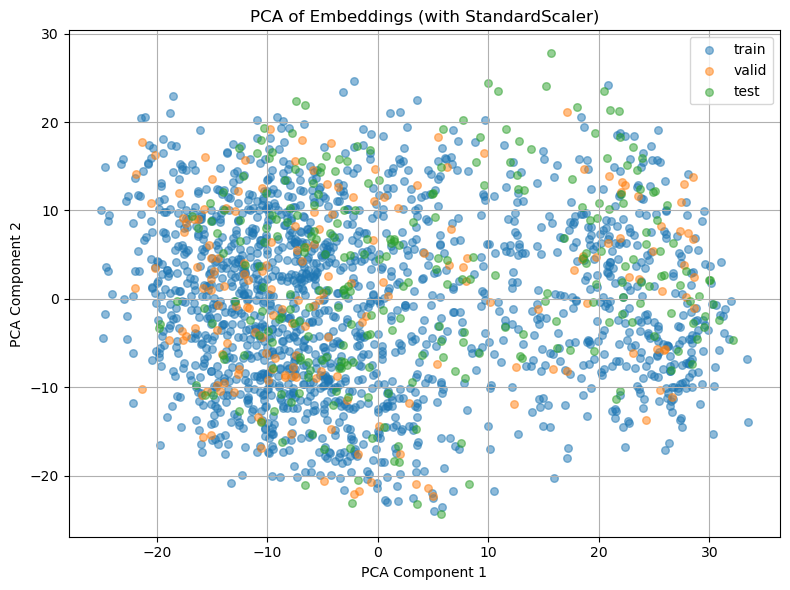

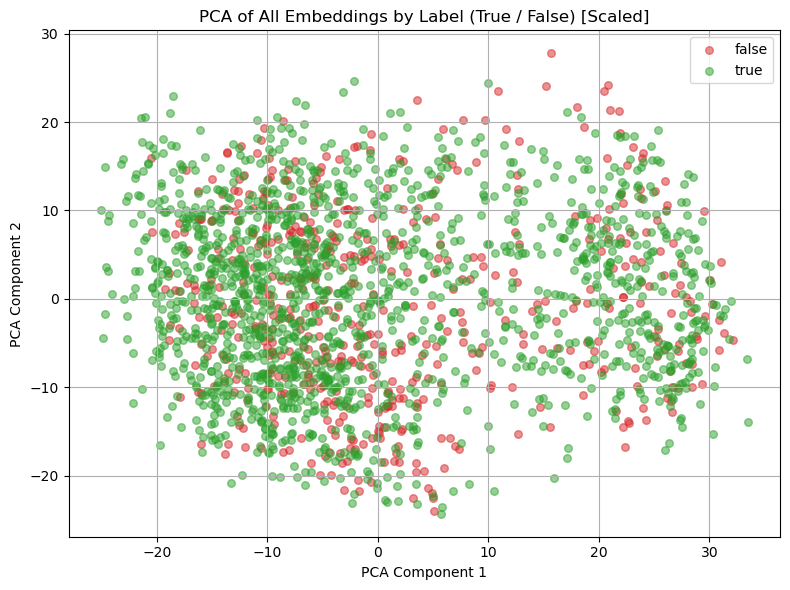

In [19]:
# üìå TimeSformer + ST-GCN ÏûÑÎ≤†Îî© Í≤∞Ìï© (ID Ï†ïÎ†¨ Ìè¨Ìï®, StandardScaler)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
DATA_ROOT = Path(r"D:\Jabez\golf\fusion\embedding_data")
AGG_METHOD = "max"  # "mean", "max", "flatten" Ï§ë ÏÑ†ÌÉù

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Ìï®Ïàò Ï†ïÏùò ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def load_split(split, model):
    base = DATA_ROOT / model / split
    emb_path = base / "embeddings.npy"
    lbl_path = base / "labels.npy"
    ids_path = base / "ids.npy"
    if not emb_path.exists() or not lbl_path.exists() or not ids_path.exists():
        print(f"‚ö†Ô∏è {split}/{model} Í≤ΩÎ°úÏóê ÌïÑÏöîÌïú ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§. Ïä§ÌÇµÌï©ÎãàÎã§.")
        return None, None, None
    emb = np.load(emb_path)
    lbl = np.load(lbl_path).ravel()
    ids = np.load(ids_path, allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if arr is None or len(arr) == 0:
        return np.empty((0, 0))
    if AGG_METHOD == "mean":    return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":     return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten": return arr.reshape(arr.shape[0], -1)
    raise ValueError("Invalid AGG_METHOD")

def align_by_ids(base_ids, target_embs, target_ids):
    id_to_emb = {k: v for k, v in zip(target_ids, target_embs)}
    aligned_embs = [id_to_emb[i] for i in base_ids if i in id_to_emb]
    return np.array(aligned_embs)

def load_and_align(split):
    X_ts, y, ids_ts = load_split(split, "timesformer")
    X_st, _, ids_st = load_split(split, "stgcnpp")

    if X_ts is None or X_st is None:
        return np.empty((0, 0)), np.array([])

    X_st = align_by_ids(ids_ts, X_st, ids_st)
    X_st = reduce_stgcn(X_st)

    if len(X_ts) != len(X_st):
        print(f"‚ùå {split} Ï†ïÎ†¨ Ïã§Ìå®: TS={len(X_ts)}, ST={len(X_st)})")
        return np.empty((0, 0)), np.array([])

    X_concat = np.concatenate([X_ts, X_st], axis=1)
    return X_concat, y

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Ï†ïÎ†¨ Î∞è Í≤∞Ìï© ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
X_tr, y_tr = load_and_align("train")
X_va, y_va = load_and_align("valid")
X_te, y_te = load_and_align("test")

X_all = np.vstack([X_tr, X_va, X_te])
y_all_split = (
    ["train"] * len(X_tr) +
    ["valid"] * len(X_va) +
    ["test"]  * len(X_te)
)
y_all_label = np.concatenate([y_tr, y_va, y_te])

if len(X_all) == 0:
    raise ValueError("Î™®Îì† splitÏóêÏÑú Ï†ïÎ†¨Îêú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§. Í≤ΩÎ°ú Î∞è ID Ï†ïÎ†¨ ÏÉÅÌÉúÎ•º ÌôïÏù∏ÌïòÏÑ∏Ïöî.")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Ï†ïÍ∑úÌôî Î∞è PCA ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
scaler = StandardScaler().fit(np.vstack([X_tr, X_va]))  # train+valid Í∏∞Ï§ÄÏúºÎ°ú fit
X_tr_scaled = scaler.transform(X_tr)
X_va_scaled = scaler.transform(X_va)
X_te_scaled = scaler.transform(X_te)
X_all_scaled = np.vstack([X_tr_scaled, X_va_scaled, X_te_scaled])

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_all_scaled)

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ ÏãúÍ∞ÅÌôî 1: split Í∏∞Ï§Ä ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(8, 6))
for label, color in zip(['train', 'valid', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
    idx = [i for i, s in enumerate(y_all_split) if s == label]
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label, alpha=0.5, s=30, color=color)
plt.legend()
plt.title("PCA of Embeddings (with StandardScaler)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ ÏãúÍ∞ÅÌôî 2: ÎùºÎ≤® Í∏∞Ï§Ä ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all_label == label
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=name, alpha=0.5, s=30, color=color)
plt.legend()
plt.title("PCA of All Embeddings by Label (True / False) [Scaled]")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


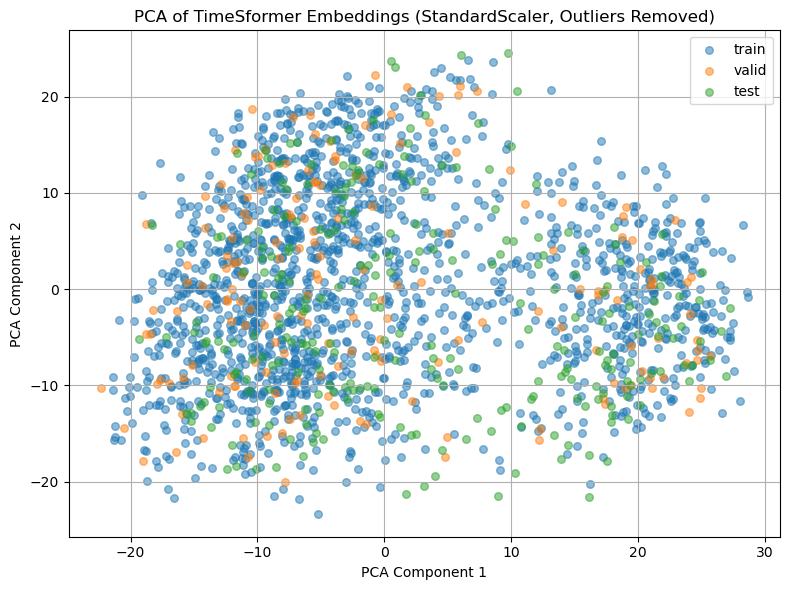

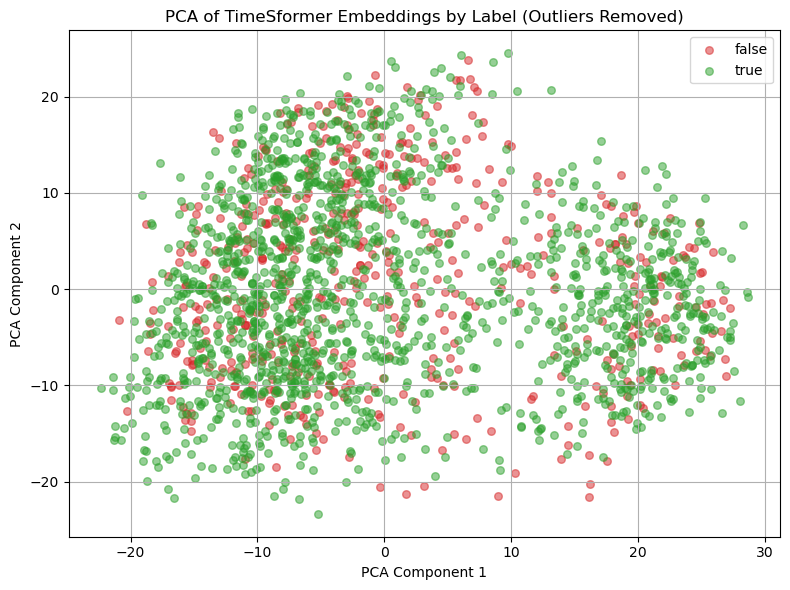

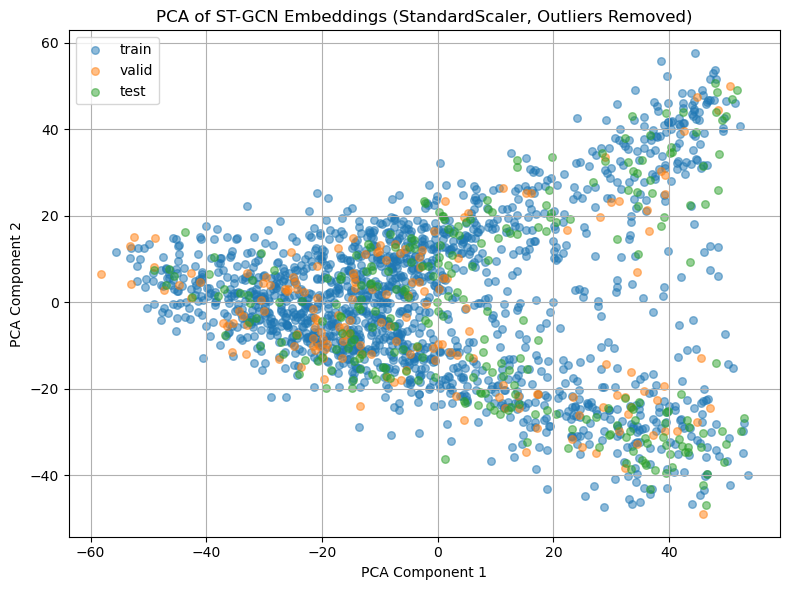

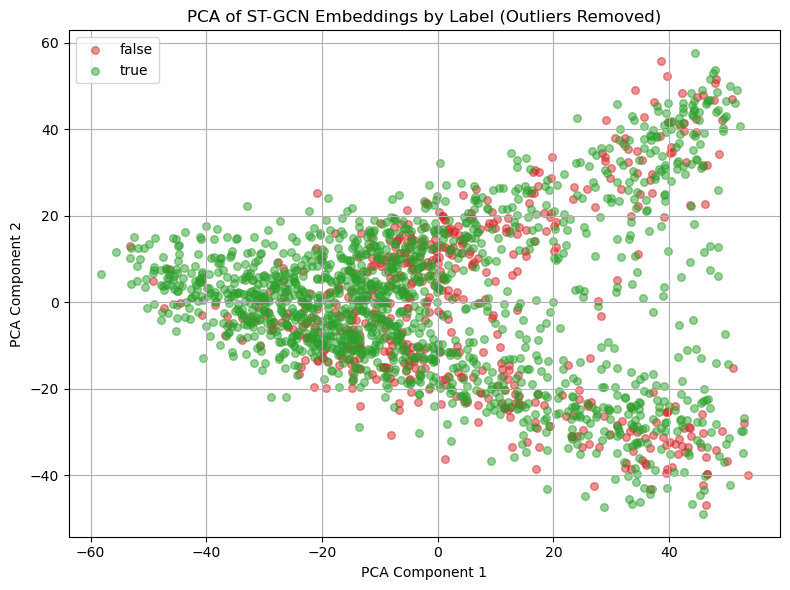

In [17]:
# üìå TimeSformer + ST-GCN ÏûÑÎ≤†Îî© Í≤∞Ìï© (ID Ï†ïÎ†¨ Ìè¨Ìï®, StandardScaler)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from scipy.stats import zscore

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
DATA_ROOT = Path(r"D:\Jabez\golf\fusion\embedding_data")
AGG_METHOD = "flatten"  # "mean", "max", "flatten" Ï§ë ÏÑ†ÌÉù

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Í∞úÎ≥Ñ Ïä§Ìä∏Î¶º Î°úÎìú Î∞è Ï†ïÎ†¨ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def load_and_align_separately(split):
    X_ts, y, ids_ts = load_split(split, "timesformer")
    X_st, _, ids_st = load_split(split, "stgcnpp")

    if X_ts is None or X_st is None:
        return np.empty((0, 0)), np.empty((0, 0)), np.array([])

    X_st = align_by_ids(ids_ts, X_st, ids_st)
    X_st = reduce_stgcn(X_st)

    if len(X_ts) != len(X_st):
        print(f"‚ùå {split} Ï†ïÎ†¨ Ïã§Ìå®: TS={len(X_ts)}, ST={len(X_st)})")
        return np.empty((0, 0)), np.empty((0, 0)), np.array([])

    return X_ts, X_st, y

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Ïù¥ÏÉÅÏπò Î∞∞Ï†ú Ìï®Ïàò ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def remove_outliers(X, y, z_thresh=3.0, min_valid_ratio=0.95):
    z = np.abs(zscore(X, axis=0, nan_policy='omit'))
    # Ï†ÑÏ≤¥ feature Ï§ë min_valid_ratio Ïù¥ÏÉÅÏù¥ z_thresh Ïù¥ÌïòÎ©¥ ÌÜµÍ≥º
    mask = (z < z_thresh).sum(axis=1) >= (X.shape[1] * min_valid_ratio)
    return X[mask], y[mask], mask

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ split Î≥Ñ Î°úÎìú ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
X_ts_tr, X_st_tr, y_tr = load_and_align_separately("train")
X_ts_va, X_st_va, y_va = load_and_align_separately("valid")
X_ts_te, X_st_te, y_te = load_and_align_separately("test")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Ï†ÑÏ≤¥ Í≤∞Ìï© ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
X_ts_all = np.vstack([X_ts_tr, X_ts_va, X_ts_te])
X_st_all = np.vstack([X_st_tr, X_st_va, X_st_te])
y_all_split = (
    ["train"] * len(X_ts_tr) +
    ["valid"] * len(X_ts_va) +
    ["test"]  * len(X_ts_te)
)
y_all_label = np.concatenate([y_tr, y_va, y_te])

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Ïù¥ÏÉÅÏπò Î∞∞Ï†ú (TS, ST-GCN Í∞ÅÍ∞Å) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
X_ts_all_no_out, y_all_label_ts, mask_ts = remove_outliers(X_ts_all, y_all_label, z_thresh=3.0)
y_all_split_ts = np.array(y_all_split)[mask_ts]

X_st_all_no_out, y_all_label_st, mask_st = remove_outliers(X_st_all, y_all_label, z_thresh=3.0)
y_all_split_st = np.array(y_all_split)[mask_st]

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Ï†ïÍ∑úÌôî Î∞è PCA (TS) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
scaler_ts = StandardScaler().fit(np.vstack([X_ts_tr, X_ts_va]))
X_ts_all_scaled = scaler_ts.transform(X_ts_all_no_out)
X_ts_2d = PCA(n_components=2).fit_transform(X_ts_all_scaled)

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Ï†ïÍ∑úÌôî Î∞è PCA (ST-GCN) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
scaler_st = StandardScaler().fit(np.vstack([X_st_tr, X_st_va]))
X_st_all_scaled = scaler_st.transform(X_st_all_no_out)
X_st_2d = PCA(n_components=2).fit_transform(X_st_all_scaled)

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ ÏãúÍ∞ÅÌôî: TimeSformer Í∏∞Ï§Ä (splitÎ≥Ñ) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(8, 6))
for label, color in zip(['train', 'valid', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
    idx = [i for i, s in enumerate(y_all_split_ts) if s == label]
    plt.scatter(X_ts_2d[idx, 0], X_ts_2d[idx, 1], label=label, alpha=0.5, s=30, color=color)
plt.title("PCA of TimeSformer Embeddings (StandardScaler, Outliers Removed)")
plt.xlabel("PCA Component 1"); plt.ylabel("PCA Component 2")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ ÏãúÍ∞ÅÌôî: TimeSformer Í∏∞Ï§Ä (ÎùºÎ≤®Î≥Ñ) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all_label_ts == label
    plt.scatter(X_ts_2d[idx, 0], X_ts_2d[idx, 1], label=name, alpha=0.5, s=30, color=color)
plt.title("PCA of TimeSformer Embeddings by Label (Outliers Removed)")
plt.xlabel("PCA Component 1"); plt.ylabel("PCA Component 2")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ ÏãúÍ∞ÅÌôî: ST-GCN Í∏∞Ï§Ä (splitÎ≥Ñ) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(8, 6))
for label, color in zip(['train', 'valid', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
    idx = [i for i, s in enumerate(y_all_split_st) if s == label]
    plt.scatter(X_st_2d[idx, 0], X_st_2d[idx, 1], label=label, alpha=0.5, s=30, color=color)
plt.title("PCA of ST-GCN Embeddings (StandardScaler, Outliers Removed)")
plt.xlabel("PCA Component 1"); plt.ylabel("PCA Component 2")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ ÏãúÍ∞ÅÌôî: ST-GCN Í∏∞Ï§Ä (ÎùºÎ≤®Î≥Ñ) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all_label_st == label
    plt.scatter(X_st_2d[idx, 0], X_st_2d[idx, 1], label=name, alpha=0.5, s=30, color=color)
plt.title("PCA of ST-GCN Embeddings by Label (Outliers Removed)")
plt.xlabel("PCA Component 1"); plt.ylabel("PCA Component 2")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()



# t-SNE UMAP

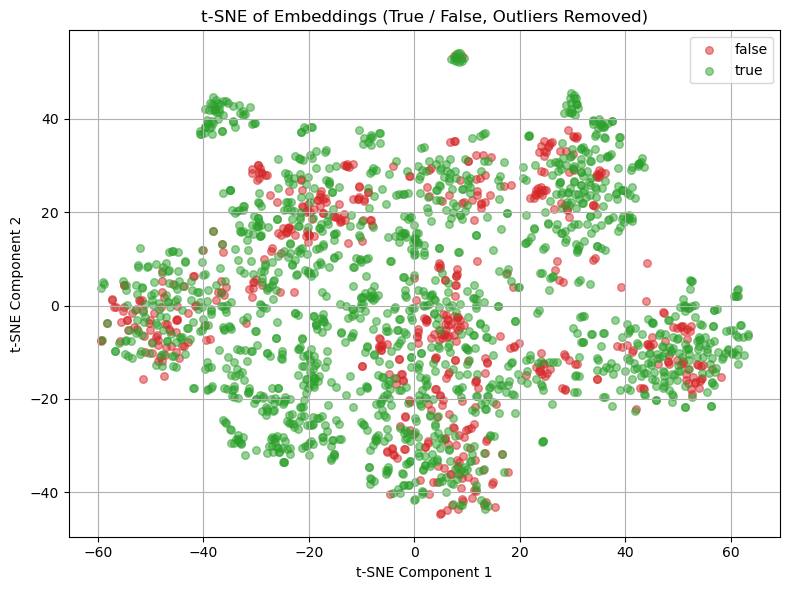

c:\Users\qqppq\anaconda3\envs\classifier_fusion\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


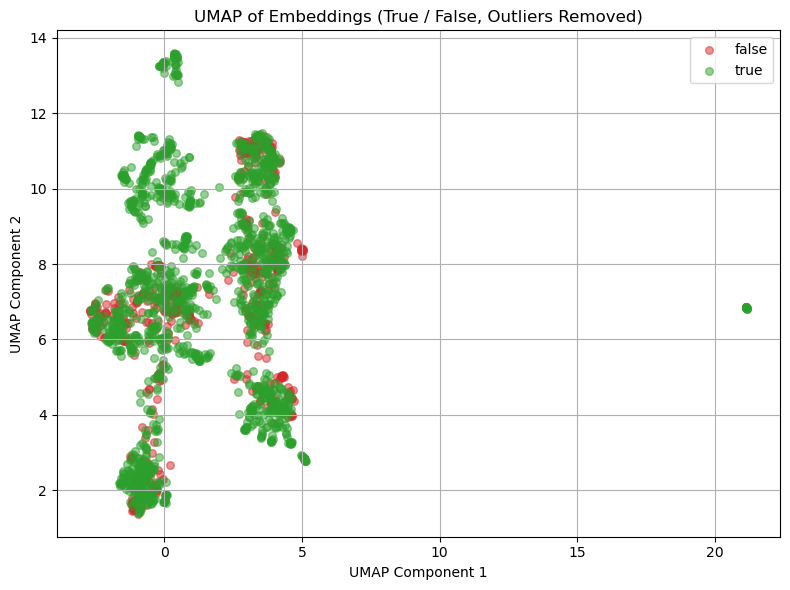

In [21]:
# üìå TimeSformer + ST-GCN t-SNE/UMAP ÏãúÍ∞ÅÌôî (ID Ï†ïÎ†¨ Í≤∞Ìï© Î≤ÑÏ†Ñ)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from scipy.stats import zscore

# ---------- [ÏïÑÎûòÎäî PCAÏôÄ ÎèôÏùºÌïú ID Ï†ïÎ†¨ & Í≤∞Ìï© ÌååÌä∏] ----------
DATA_ROOT = Path(r"D:\Jabez\golf\fusion\embedding_data")
AGG_METHOD = "max"  # "mean", "max", "flatten" Ï§ë ÏÑ†ÌÉù

def load_split(split, model):
    base = DATA_ROOT / model / split
    emb_path = base / "embeddings.npy"
    lbl_path = base / "labels.npy"
    ids_path = base / "ids.npy"
    if not emb_path.exists() or not lbl_path.exists() or not ids_path.exists():
        print(f"‚ö†Ô∏è {split}/{model} Í≤ΩÎ°úÏóê ÌïÑÏöîÌïú ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§. Ïä§ÌÇµÌï©ÎãàÎã§.")
        return None, None, None
    emb = np.load(emb_path)
    lbl = np.load(lbl_path).ravel()
    ids = np.load(ids_path, allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if arr is None or len(arr) == 0:
        return np.empty((0, 0))
    if AGG_METHOD == "mean":    return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":     return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten": return arr.reshape(arr.shape[0], -1)
    raise ValueError("Invalid AGG_METHOD")

def align_by_ids(base_ids, target_embs, target_ids):
    id_to_emb = {k: v for k, v in zip(target_ids, target_embs)}
    aligned_embs = [id_to_emb[i] for i in base_ids if i in id_to_emb]
    return np.array(aligned_embs)

def load_and_align(split):
    X_ts, y, ids_ts = load_split(split, "timesformer")
    X_st, _, ids_st = load_split(split, "stgcnpp")

    if X_ts is None or X_st is None:
        return np.empty((0, 0)), np.array([])

    X_st = align_by_ids(ids_ts, X_st, ids_st)
    X_st = reduce_stgcn(X_st)

    if len(X_ts) != len(X_st):
        print(f"‚ùå {split} Ï†ïÎ†¨ Ïã§Ìå®: TS={len(X_ts)}, ST={len(X_st)})")
        return np.empty((0, 0)), np.array([])

    X_concat = np.concatenate([X_ts, X_st], axis=1)
    return X_concat, y

def remove_outliers(X, y, z_thresh=3.0, min_valid_ratio=0.95):
    z = np.abs(zscore(X, axis=0, nan_policy='omit'))
    # Ï†ÑÏ≤¥ feature Ï§ë min_valid_ratio Ïù¥ÏÉÅÏù¥ z_thresh Ïù¥ÌïòÎ©¥ ÌÜµÍ≥º
    mask = (z < z_thresh).sum(axis=1) >= (X.shape[1] * min_valid_ratio)
    return X[mask], y[mask], mask

# Ï†ïÎ†¨ Î∞è Í≤∞Ìï©
X_tr, y_tr = load_and_align("train")
X_va, y_va = load_and_align("valid")
X_te, y_te = load_and_align("test")

if len(X_tr) == 0 or len(X_va) == 0 or len(X_te) == 0:
    raise ValueError("train/valid/test split Îç∞Ïù¥ÌÑ∞ Ï†ïÎ†¨ Ïã§Ìå®. ID ÏùºÏπò Ïó¨Î∂Ä ÌôïÏù∏!")

# ---------- [Ïù¥ÏÉÅÏπò Ï†úÍ±∞] ----------
X_all = np.vstack([X_tr, X_va, X_te])
y_all = np.concatenate([y_tr, y_va, y_te])
X_all_no_out, y_all_no_out, mask = remove_outliers(X_all, y_all, z_thresh=3.0)

# ---------- [Ï†ïÍ∑úÌôî] ----------
scaler = StandardScaler().fit(np.vstack([X_tr, X_va]))
X_all_scaled = scaler.transform(X_all_no_out)

# ---------- [t-SNE ÏãúÍ∞ÅÌôî] ----------
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_all_scaled)

plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all_no_out == label
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=name, alpha=0.5, s=30, color=color)

plt.legend()
plt.title("t-SNE of Embeddings (True / False, Outliers Removed)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- [UMAP ÏãúÍ∞ÅÌôî] ----------
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_all_scaled)

plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all_no_out == label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], label=name, alpha=0.5, s=30, color=color)

plt.legend()
plt.title("UMAP of Embeddings (True / False, Outliers Removed)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
